In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

In [2]:
# initialize two dict for storing data for myo-1 and myo-2
def init_data():
    data1 = dict()
    data1['ori'] = {'time':[], 'ori': []}
    data1['acc'] = {'time':[], 'acc': []}
    data1['gyr'] = {'time':[], 'gyr': []}

    data2 = dict()
    data2['ori'] = {'time':[], 'ori': []}
    data2['acc'] = {'time':[], 'acc': []}
    data2['gyr'] = {'time':[], 'gyr': []}
    
    return data1, data2

In [3]:
def read_file(filepath, data1, data2):
    with open(filepath) as fp:
        for cnt, line in enumerate(fp):
            info = line.strip().split('|')
            connection = int(info[1].strip()[-1])
            data_type = info[0].strip()
            time = float(info[2].split(':')[-1])
            x = float(info[3].split(':')[-1])
            y = float(info[4].split(':')[-1])
            z = float(info[5].split(':')[-1])
            if connection == 0:
                data1[data_type]['time'].append(time)
                data1[data_type][data_type].append([x, y, z])
            elif connection == 1:
                data2[data_type]['time'].append(time)
                data2[data_type][data_type].append([x, y, z])

In [4]:
def plot_data(time_stamp, data, label, xrange, axis='xyz', xlabels=10, peaks=None):
    fig = plt.figure(figsize=(16,6))
    if 'x' in axis:
        plt.plot(time_stamp, data[:,0], 'red')
    if 'y' in axis:
        plt.plot(time_stamp, data[:,1], 'blue')
    if 'z' in axis:
        plt.plot(time_stamp, data[:,2], 'green')

#     plt.xticks(x_ticks)
    if xrange == None:
        xrange = [time_stamp[0]-0.5, time_stamp[-1]+0.5]
    
    start = xrange[0]
    end = xrange[1]
    time_interval = (end-start)/xlabels
    x_ticks = [(start + i*time_interval) for i in range(xlabels+1)]
    
    if peaks:
        plt.plot(peaks[0], peaks[1], "x", c='darkred')
    
    plt.xlim(xrange)
    plt.xticks(x_ticks)
    legend_list = []
    for ax in axis:
        legend_list.append(label+'_'+ax)
    plt.legend(legend_list)
    plt.show()

### Test Walk1
logo on the right

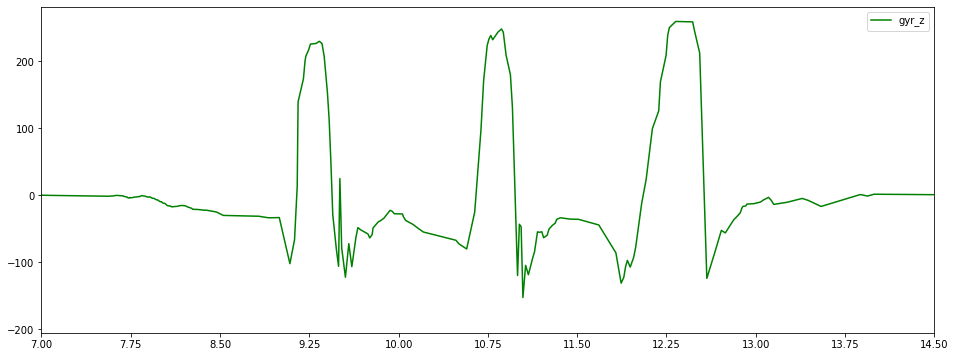

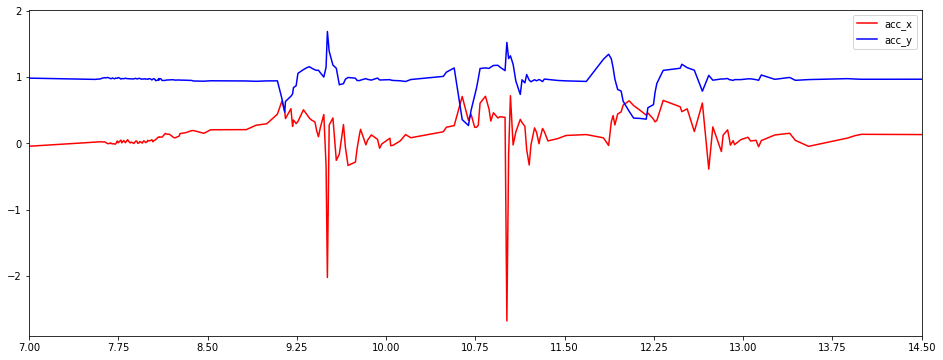

In [5]:
filepath = 'walk1-output-2021-05-03-20-23-32.txt'

data1, data2 = init_data()
read_file(filepath, data1, data2)

# get data for myo 1
ori_time_1 = np.array(data1['ori']['time'])
ori_1 = np.array(data1['ori']['ori'])

acc_time_1 = np.array(data1['acc']['time'])
acc_1 = np.array(data1['acc']['acc'])/2048

gyr_time_1 = np.array(data1['gyr']['time'])
gyr_1 = np.array(data1['gyr']['gyr'])/16.4

# get data for myo 2
ori_time_2 = np.array(data2['ori']['time'])
ori_2 = np.array(data2['ori']['ori'])

acc_time_2 = np.array(data2['acc']['time'])
acc_2 = np.array(data2['acc']['acc'])/2048

gyr_time_2 = np.array(data2['gyr']['time'])
gyr_2 = np.array(data2['gyr']['gyr'])/16.4

# data1 right leg, 3 steps
plot_data(gyr_time_1, -gyr_1, 'gyr', [7, 14.5], 'z')
plot_data(acc_time_1, acc_1, 'acc', [7, 14.5], 'xy')

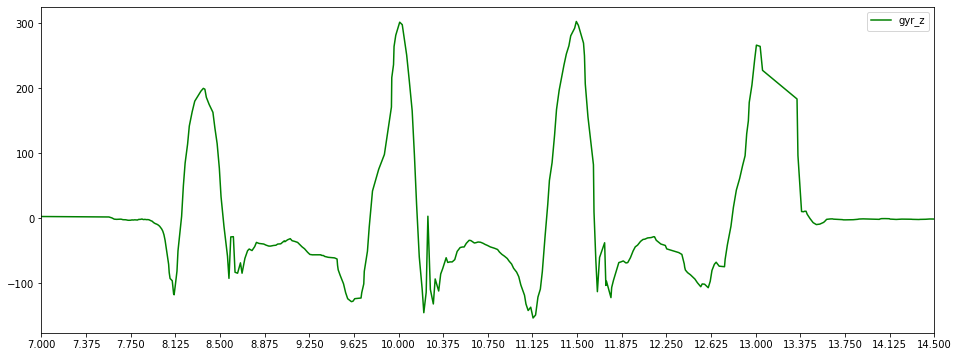

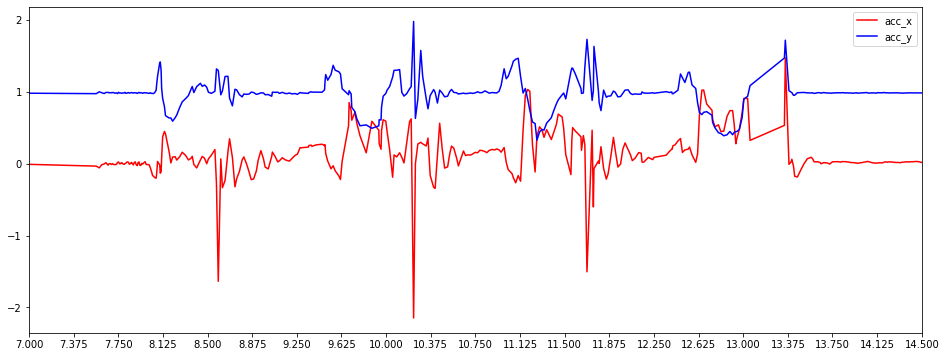

In [6]:
# data2 left leg, 4 steps
plot_data(gyr_time_2, -gyr_2, 'gyr', [7, 14.5], 'z', xlabels=20)
plot_data(acc_time_2, acc_2, 'acc', [7, 14.5], 'xy', xlabels=20)

### segmentation

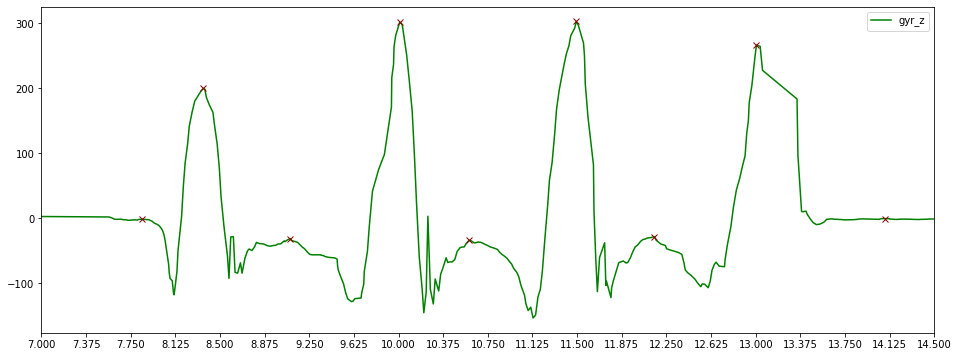

In [7]:
indexes, peaks = find_peaks(-gyr_2[:,2], height=-50, distance=25)

gyr_peaks = peaks['peak_heights']
peak_times = gyr_time_2[indexes]

plot_data(gyr_time_2, -gyr_2, 'gyr', [7, 14.5], 'z', xlabels=20, peaks=[peak_times, gyr_peaks])

In [8]:
peak_times = peak_times[(peak_times > 7) & (peak_times < 14.5)]
print(peak_times)

[ 7.84390163  8.35980129  9.0901227  10.00946593 10.59261227 11.49319911
 12.14332771 13.00598454 14.08653569]


In [9]:
def filter_index(xrange, x):
    x_min = xrange[0]
    x_max = xrange[1]
    indexes = [-1, -1]
    for i in range(len(x)):
        if x[i] >= x_min and indexes[0] == -1:
            indexes[0] = i
        if x[i] > x_max and indexes[1] == -1:
            indexes[1] = i + 1
            break
    return indexes        

In [11]:
start, end = filter_index([7,14.5], gyr_time_2)
print(start, end)

142 496


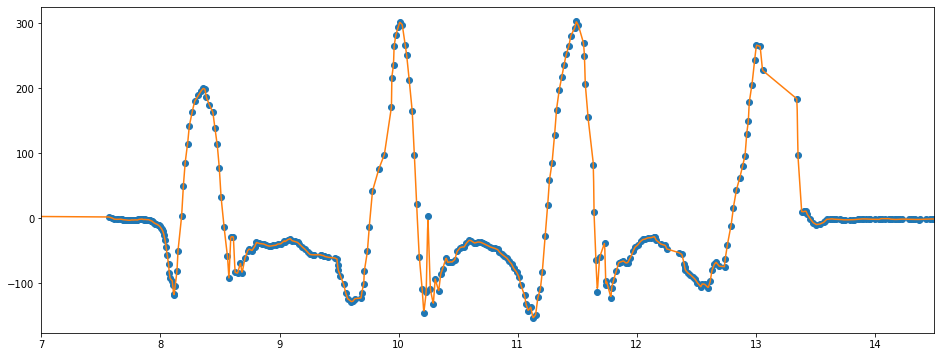

In [12]:
f = interp1d(gyr_time_2, -gyr_2[:,2], kind='linear')
x_gyrz_intep = np.linspace(7, 14.5, num=2001, endpoint=True)
y_gyrz_intep = f(x_gyrz_intep)

plt.figure(figsize=(16,6))
plt.plot(gyr_time_2[start:end], -gyr_2[:,2][start:end], 'o', x_gyrz_intep, y_gyrz_intep, '-')
plt.xlim([7,14.5])
plt.show()

### orientation theta

cycle 1 starts at 7.843901634216309 s and ends at 9.090122699737549 s
cycle 1 starts at time_stamp idx 168 and ends at time_stamp idx 252 
7.145467015903517


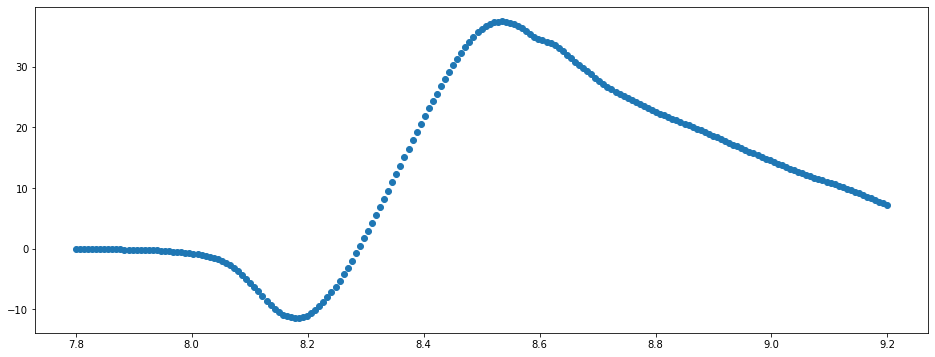

In [70]:
# cycle 1
t_start = peak_times[0]
t_end = peak_times[2]
print('cycle 1 starts at {} s and ends at {} s'.format(t_start, t_end))
t_idx = filter_index([t_start, t_end], gyr_time_2)
print('cycle 1 starts at time_stamp idx {} and ends at time_stamp idx {} '.format(t_idx[0], t_idx[1]))

time_c1 = np.linspace(7.8, 9.2, num=201, endpoint=True)

# interpolate gyro data
gyr_intp = interp1d(gyr_time_2, -gyr_2[:,2], kind='linear')
gyr_c1 = gyr_intp(time_c1)

theta_c1 = []
for i in range(len(time_c1)):
    theta_c1.append(np.trapz(gyr_c1[:i], x=time_c1[:i]))
theta_c1 = np.array(theta_c1)

plt.figure(figsize=(16,6))
plt.plot(time_c1, theta_c1, 'o')
print(theta_c1[-1])

### acc a_hor

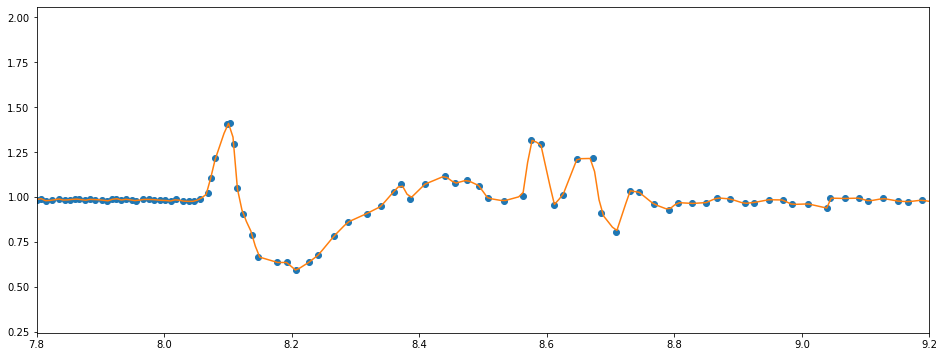

In [40]:
ax_intp = interp1d(acc_time_2, -acc_2[:,0], kind='linear')
ax_c1 = ax_intp(time_c1)

ay_intp = interp1d(acc_time_2, acc_2[:,1], kind='linear')
ay_c1 = ay_intp(time_c1)

plt.figure(figsize=(16,6))
# plt.plot(acc_time_2, -acc_2[:,0], 'o', time_c1, ax_c1, '-')
plt.plot(acc_time_2, acc_2[:,1], 'o', time_c1, ay_c1, '-')
plt.xlim([7.8,9.2])
plt.show()

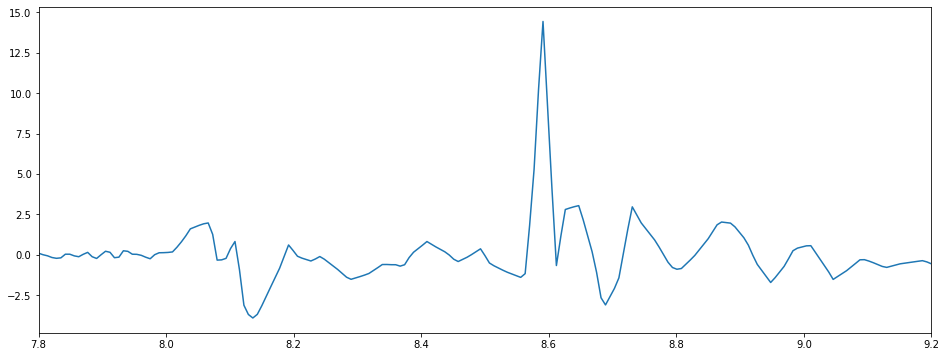

In [41]:
cos_theta = np.array([math.cos(math.radians(theta)) for theta in theta_c1])
sin_theta = np.array([math.sin(math.radians(theta)) for theta in theta_c1])

a_hor = (cos_theta * ax_c1 + sin_theta * (ay_c1 - 1)) * 9.81

plt.figure(figsize=(16,6))
plt.plot(time_c1, a_hor, '-')
plt.xlim([7.8,9.2])
plt.show()

### integrate to get v_hor

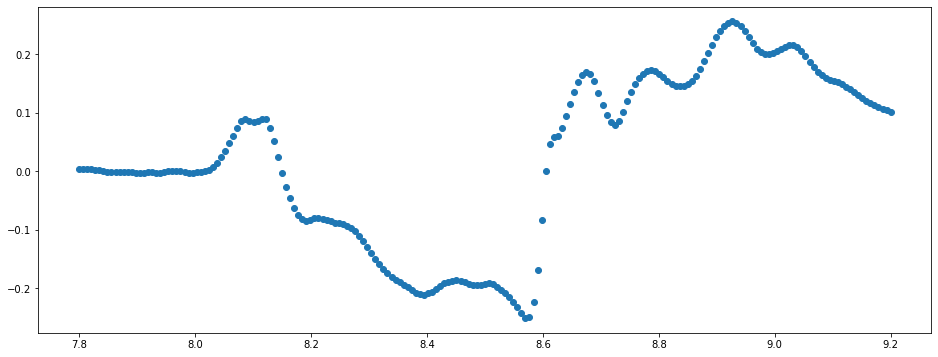

In [42]:
omega_0 = -gyr_2[:,2][t_idx[0]]
v_tang = - math.radians(omega_0) * 0.21 # D = 21 cm
v_hor_gyr = cos_theta[0] * v_tang

v_hor_intg = []
for i in range(len(time_c1)):
    v_hor_intg.append(np.trapz(a_hor[:i], x=time_c1[:i]) + v_hor_gyr) 
v_hor_intg = np.array(v_hor_intg)

plt.figure(figsize=(16,6))
plt.plot(time_c1, v_hor_intg, 'o')

In [43]:
omega_end = gyr_intp(9.2)
v_tang_end = -math.radians(omega_end) * 0.21 # D = 21 cm
v_hor_end = cos_theta[-1] * v_tang_end
print(v_hor_end)

0.16503299366867763


### get v_hor_corrected

In [44]:
v_hor_corrected = v_hor_intg + (v_hor_end - v_hor_intg[-1]) / (time_c1[-1]-time_c1[-0]) * (time_c1-time_c1[-0])
print(v_hor_corrected[0], v_hor_corrected[-1])

0.0035757965162810657 0.16503299366867763


In [45]:
### get stride_length

first step stride length is: 0.07580609358454299


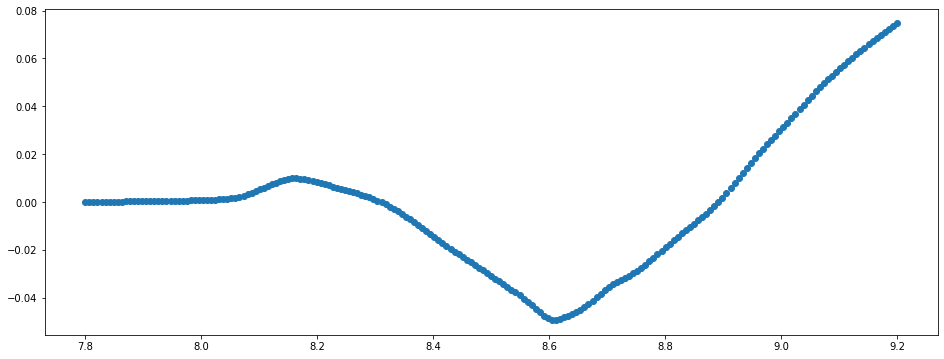

In [46]:
stide_length = np.trapz(v_hor_corrected, x=time_c1)
print('first step stride length is:', stide_length)

distance = []
for i in range(len(time_c1)):
    distance.append(np.trapz(v_hor_corrected[:i], x=time_c1[:i])) 
distance = np.array(distance)

plt.figure(figsize=(16,6))
plt.plot(time_c1, distance, 'o')

cycle 2 starts at 9.090122699737549 s and ends at 10.592612266540527 s
cycle 2 starts at time_stamp idx 250 and ends at time_stamp idx 323 


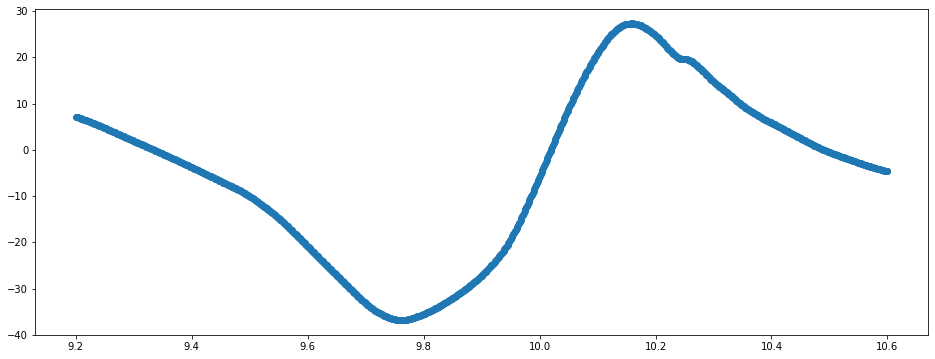

In [79]:
# cycle 2
t_start = peak_times[2]
t_end = peak_times[4]
print('cycle 2 starts at {} s and ends at {} s'.format(t_start, t_end))
t_idx = filter_index([t_start, t_end], gyr_time_2)
print('cycle 2 starts at time_stamp idx {} and ends at time_stamp idx {} '.format(t_idx[0], t_idx[1]))

time_c2 = np.linspace(9.2, 10.6, num=1001, endpoint=True)

# interpolate gyro data
gyr_c2 = gyr_intp(time_c2)

theta_c2 = []
for i in range(len(time_c2)):
    theta_c2.append(np.trapz(gyr_c2[:i], x=time_c2[:i]) + theta_c1[-1])
theta_c2 = np.array(theta_c2)

plt.figure(figsize=(16,6))
plt.plot(time_c2, theta_c2, 'o')

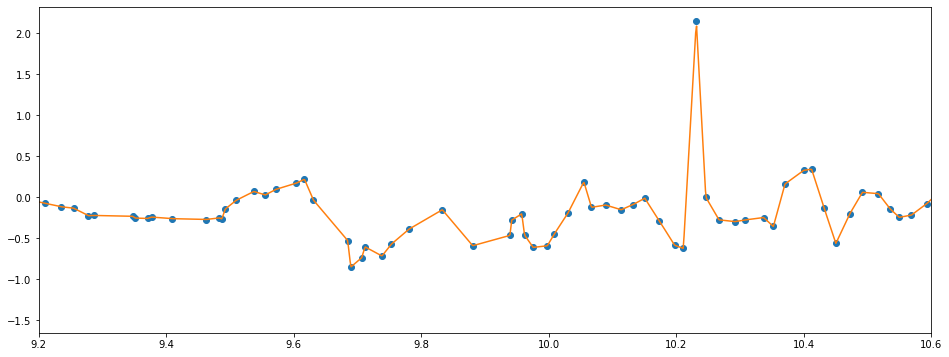

In [80]:
ax_intp = interp1d(acc_time_2, -acc_2[:,0], kind='linear')
ax_c2 = ax_intp(time_c2)

ay_intp = interp1d(acc_time_2, acc_2[:,1], kind='linear')
ay_c2 = ay_intp(time_c2)

plt.figure(figsize=(16,6))
plt.plot(acc_time_2, -acc_2[:,0], 'o', time_c2, ax_c2, '-')
# plt.plot(acc_time_2, acc_2[:,1], 'o', time_c2, ay_c2, '-')
plt.xlim([9.2,10.6])
plt.show()

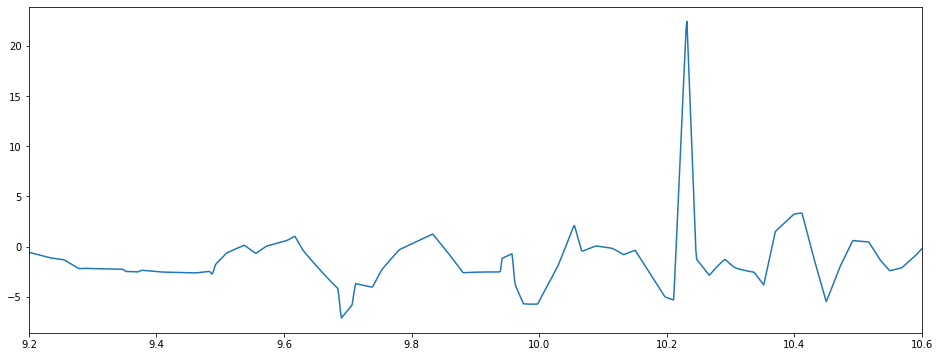

In [128]:
cos_theta = np.array([math.cos(math.radians(theta)) for theta in theta_c2])
sin_theta = np.array([math.sin(math.radians(theta)) for theta in theta_c2])

a_hor = (cos_theta * ax_c2 + sin_theta * (ay_c2 - 1)) * 9.81

plt.figure(figsize=(16,6))
plt.plot(time_c2, a_hor, '-')
plt.xlim([9.2,10.6])
plt.show()

# Note, a_hor has the greatest impact on v_hor, and stride length

0.16503299366867763


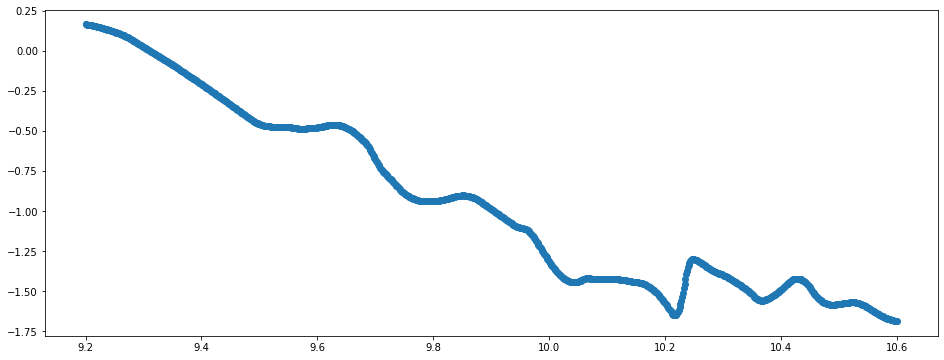

In [129]:
omega_0 = gyr_intp(9.2)
v_tang = - math.radians(omega_0) * 0.21 # D = 21 cm
v_hor_gyr = cos_theta[0] * v_tang
print(v_hor_gyr)

v_hor_intg = []
for i in range(len(time_c2)):
    v_hor_intg.append(np.trapz(a_hor[:i], x=time_c2[:i]) + v_hor_gyr) 
v_hor_intg = np.array(v_hor_intg)

plt.figure(figsize=(16,6))
plt.plot(time_c2, v_hor_intg, 'o')

In [130]:
omega_end = gyr_intp(10.6)
v_tang_end = -math.radians(omega_end) * 0.21 # D = 21 cm
v_hor_end = cos_theta[-1] * v_tang_end
print(v_hor_end)

0.12417275164511803


In [131]:
v_hor_corrected = v_hor_intg + (v_hor_end - v_hor_intg[-1]) / (time_c2[-1]-time_c2[-0]) * (time_c2-time_c2[-0])
print(v_hor_corrected[0], v_hor_corrected[-1])

0.16503299366867763 0.1241727516451181


cycle 2 stride length is: -0.04586522542324877


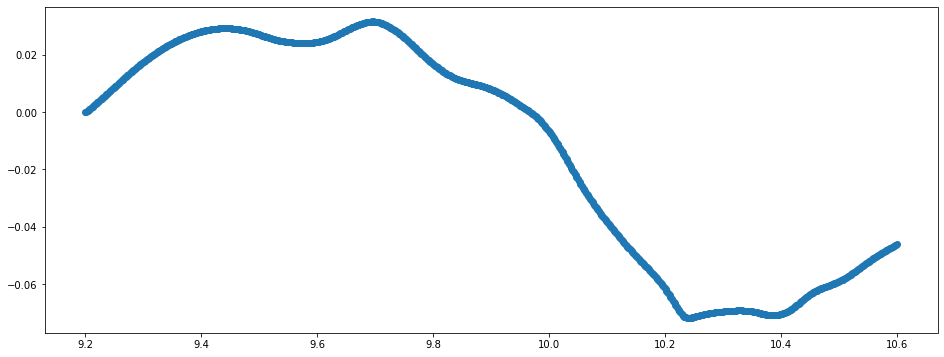

In [132]:
stide_length_2 = np.trapz(v_hor_corrected, x=time_c2)
print('cycle 2 stride length is:', stide_length_2)

distance = []
for i in range(len(time_c2)):
    distance.append(np.trapz(v_hor_corrected[:i], x=time_c2[:i])) 
distance = np.array(distance)

plt.figure(figsize=(16,6))
plt.plot(time_c2, distance, 'o')

### haven't figured out what exact angles the orientation represent

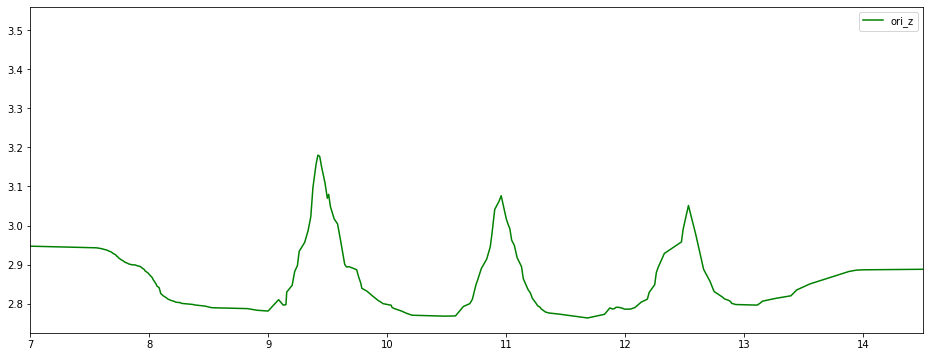

In [280]:
# ori_1[:,0] = [x if x > 0 else x+2*math.pi for x in ori_1[:,0]]
# ori_1[:,2] = [x if x > 0 else x+2*math.pi for x in ori_1[:,2]]
plot_data(ori_time_1, ori_1, 'ori', [7, 14.5], 'x')
plot_data(ori_time_1, ori_1, 'ori', [7, 14.5], 'z')

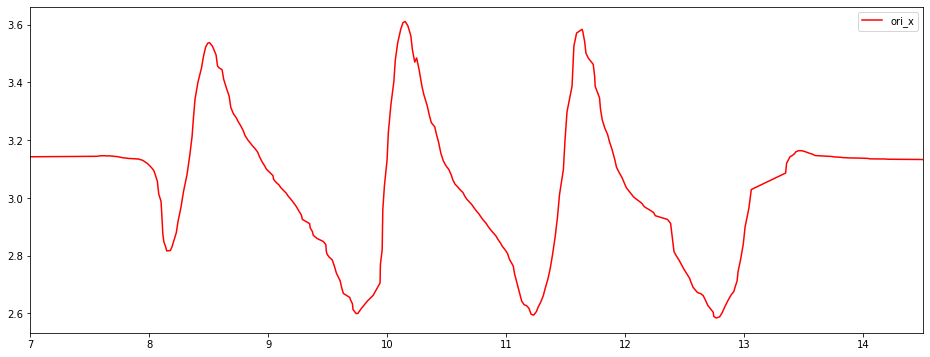

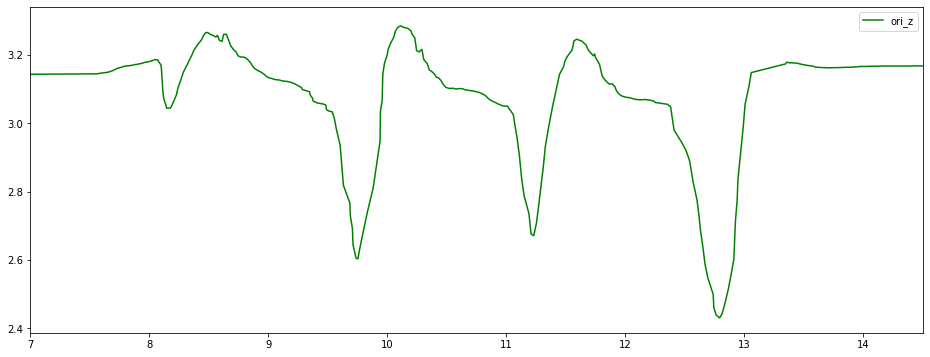

In [281]:
# ori_2[:,0] = [x if x > 0 else x+2*math.pi for x in ori_2[:,0]]
# ori_2[:,2] = [x if x > 0 else x+2*math.pi for x in ori_2[:,2]]
plot_data(ori_time_2, ori_2, 'ori', [7, 14.5], 'x')
plot_data(ori_time_2, ori_2, 'ori', [7, 14.5], 'z')

### Test-Walk2
logo on the front

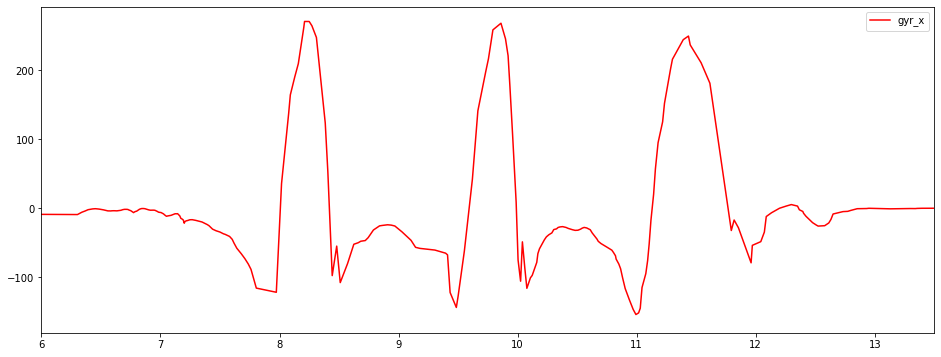

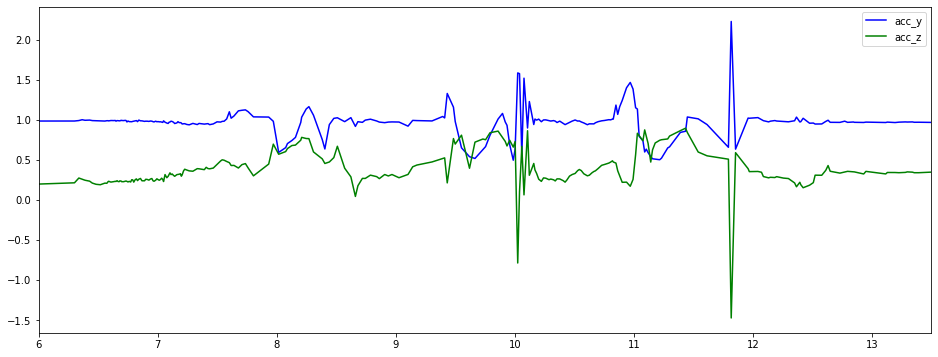

In [296]:
filepath = 'walk2-output-2021-05-03-20-25-58.txt'

data1, data2 = init_data()
read_file(filepath, data1, data2)

# get data for myo 1
ori_time_1 = np.array(data1['ori']['time'])
ori_1 = np.array(data1['ori']['ori'])

acc_time_1 = np.array(data1['acc']['time'])
acc_1 = np.array(data1['acc']['acc'])/2048

gyr_time_1 = np.array(data1['gyr']['time'])
gyr_1 = np.array(data1['gyr']['gyr'])/16.4

# get data for myo 2
ori_time_2 = np.array(data2['ori']['time'])
ori_2 = np.array(data2['ori']['ori'])

acc_time_2 = np.array(data2['acc']['time'])
acc_2 = np.array(data2['acc']['acc'])/2048

gyr_time_2 = np.array(data2['gyr']['time'])
gyr_2 = np.array(data2['gyr']['gyr'])/16.4

# data1, right leg, 3 steps
plot_data(gyr_time_1, gyr_1, 'gyr', [6, 13.5], 'x')
plot_data(acc_time_1, acc_1, 'acc', [6, 13.5], 'yz')

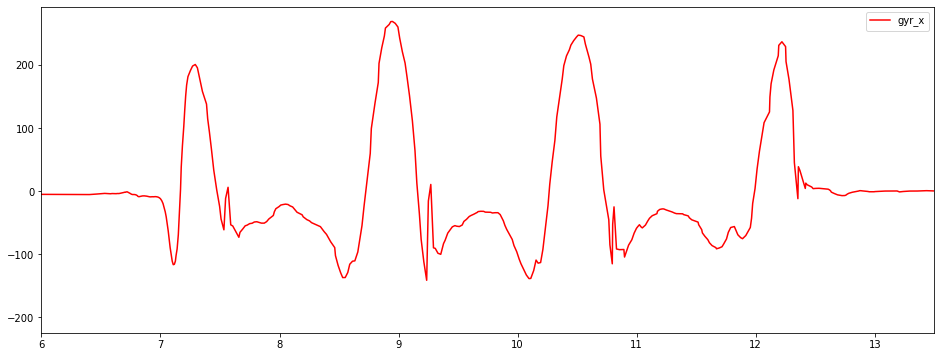

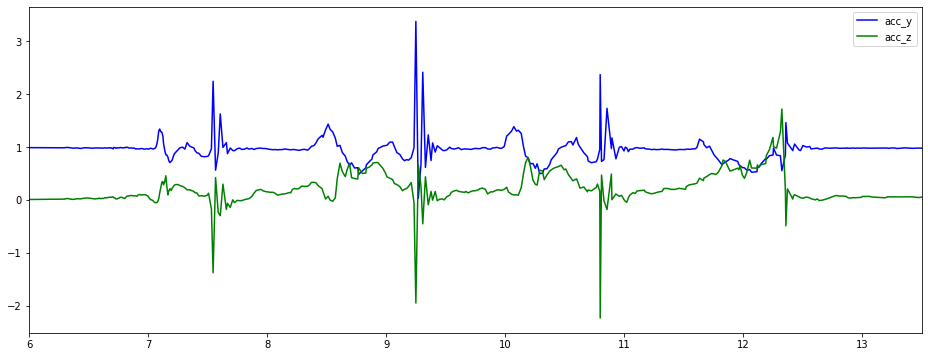

In [297]:
# data2, left leg, 4 steps
plot_data(gyr_time_2, gyr_2, 'gyr', [6, 13.5], 'x')
plot_data(acc_time_2, acc_2, 'acc', [6, 13.5], 'yz')

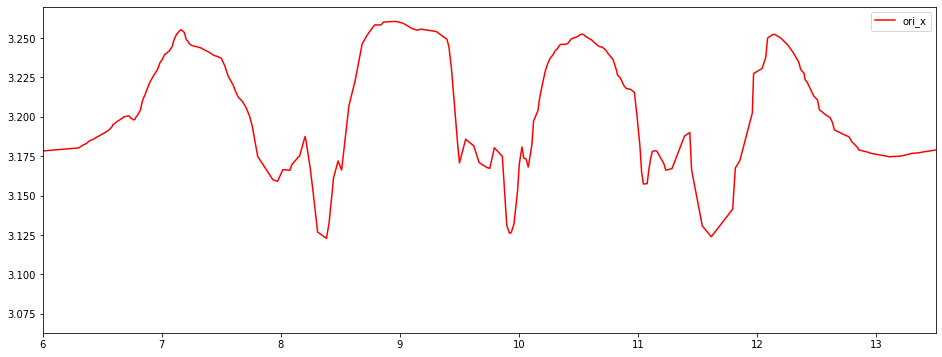

In [298]:
# left leg orientation
# ori_1[:,0] = [x if x > 0 else x+2*math.pi for x in ori_1[:,0]]
# ori_1[:,2] = [x if x > 0 else x+2*math.pi for x in ori_1[:,2]]
plot_data(ori_time_1, ori_1, 'ori', [6, 13.5], 'x')
plot_data(ori_time_1, ori_1, 'ori', [6, 13.5], 'z')

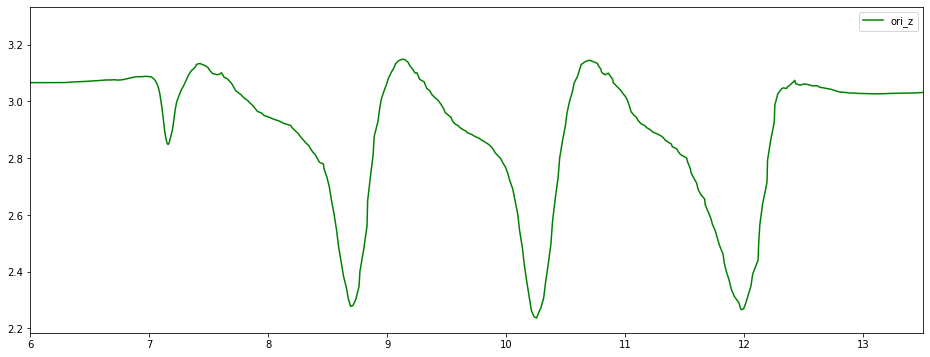

In [299]:
# right leg orientation
# ori_2[:,0] = [x if x > 0 else x+2*math.pi for x in ori_2[:,0]]
# ori_2[:,2] = [x if x > 0 else x+2*math.pi for x in ori_2[:,2]]
plot_data(ori_time_2, ori_2, 'ori', [6, 13.5], 'x')
plot_data(ori_time_2, ori_2, 'ori', [6, 13.5], 'z')

### ------------------Preliminaryrandom tests to figure out axis and orientation--------------------

In [116]:
filepath = 'test-rotation-output-2021-05-02-19-02-16.txt'

data1, data2 = init_data()
read_file(filepath, data1, data2)

# get data for myo 1
ori_time_1 = np.array(data1['ori']['time'])
ori_1 = np.array(data1['ori']['ori'])

acc_time_1 = np.array(data1['acc']['time'])
acc_1 = np.array(data1['acc']['acc'])/2048

gyr_time_1 = np.array(data1['gyr']['time'])
gyr_1 = np.array(data1['gyr']['gyr'])/16.4

# get data for myo 2
ori_time_2 = np.array(data2['ori']['time'])
ori_2 = np.array(data2['ori']['ori'])

acc_time_2 = np.array(data2['acc']['time'])
acc_2 = np.array(data2['acc']['acc'])/2048

gyr_time_2 = np.array(data2['gyr']['time'])
gyr_2 = np.array(data2['gyr']['gyr'])/16.4

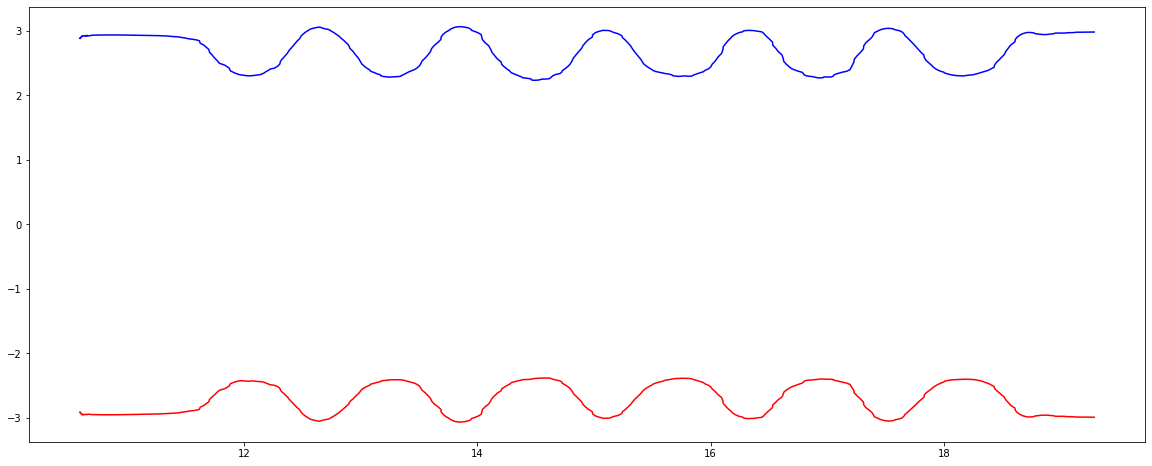

In [117]:
plt.figure(figsize=(20,8))
plt.plot(ori_time_1, ori_1[:,0],'r')
plt.plot(ori_time_1, ori_1[:,2],'b')
# plt.plot(ori_time_2, ori_2[:,0],'b')
plt.show()

In [154]:
filepath = 'test-ori1-output-2021-05-02-19-25-03.txt'

data1, data2 = init_data()
read_file(filepath, data1, data2)

# get data for myo 1
ori_time_1 = np.array(data1['ori']['time'])
ori_1 = np.array(data1['ori']['ori'])

acc_time_1 = np.array(data1['acc']['time'])
acc_1 = np.array(data1['acc']['acc'])/2048

gyr_time_1 = np.array(data1['gyr']['time'])
gyr_1 = np.array(data1['gyr']['gyr'])/16.4

# get data for myo 2
ori_time_2 = np.array(data2['ori']['time'])
ori_2 = np.array(data2['ori']['ori'])

acc_time_2 = np.array(data2['acc']['time'])
acc_2 = np.array(data2['acc']['acc'])/2048

gyr_time_2 = np.array(data2['gyr']['time'])
gyr_2 = np.array(data2['gyr']['gyr'])/16.4

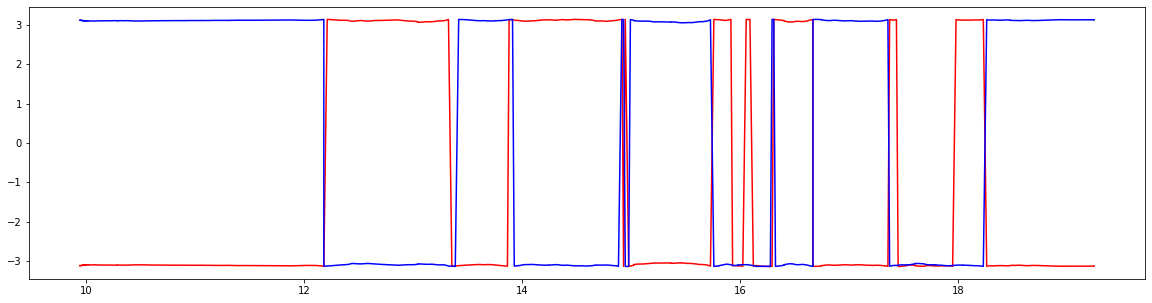

In [155]:
plt.figure(figsize=(20,5))
plt.plot(ori_time_1, ori_1[:,0],'r')
plt.plot(ori_time_1, ori_1[:,2],'b')
plt.show()

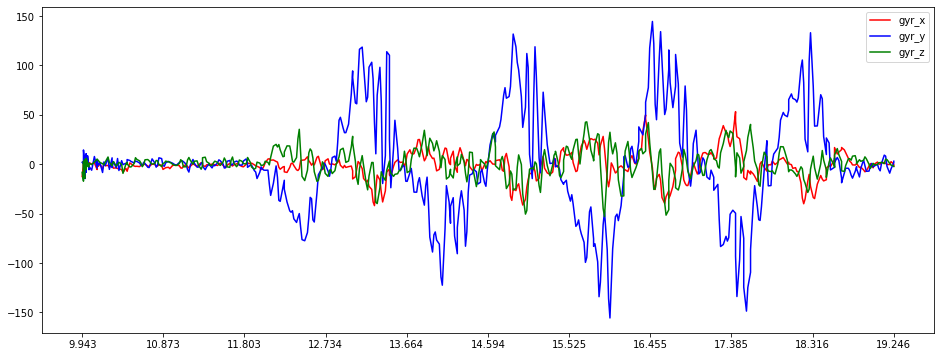

In [157]:
plot_data(gyr_time_1, gyr_1, 'gyr', 'xyz')
plot_data(acc_time_1, acc_1, 'acc', 'xyz')

In [158]:
filepath = 'test-ori2-output-2021-05-02-19-33-12.txt'

data1, data2 = init_data()
read_file(filepath, data1, data2)

# get data for myo 1
ori_time_1 = np.array(data1['ori']['time'])
ori_1 = np.array(data1['ori']['ori'])

acc_time_1 = np.array(data1['acc']['time'])
acc_1 = np.array(data1['acc']['acc'])/2048

gyr_time_1 = np.array(data1['gyr']['time'])
gyr_1 = np.array(data1['gyr']['gyr'])/16.4

# get data for myo 2
ori_time_2 = np.array(data2['ori']['time'])
ori_2 = np.array(data2['ori']['ori'])

acc_time_2 = np.array(data2['acc']['time'])
acc_2 = np.array(data2['acc']['acc'])/2048

gyr_time_2 = np.array(data2['gyr']['time'])
gyr_2 = np.array(data2['gyr']['gyr'])/16.4

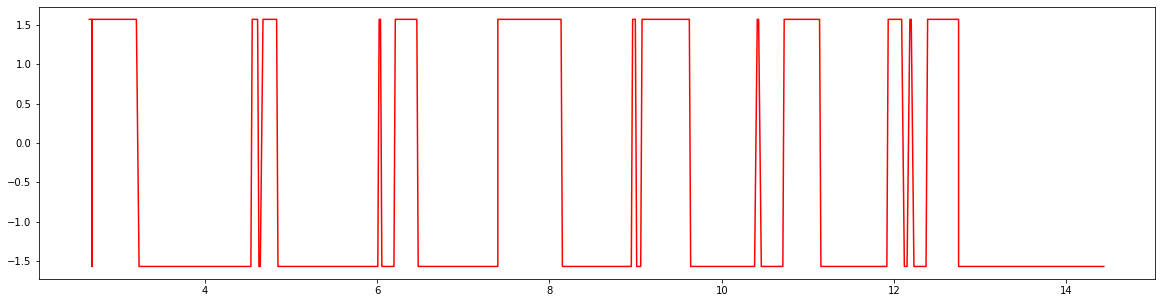

In [159]:
plt.figure(figsize=(20,5))
plt.plot(ori_time_1, ori_1[:,1],'r')
# plt.plot(ori_time_1, ori_1[:,2],'b')
plt.show()

In [160]:
plot_data(gyr_time_1, gyr_1, 'gyr', 'xyz')
plot_data(acc_time_1, acc_1, 'acc', 'xyz')

In [140]:
filepath = 'test-ori3-output-2021-05-02-19-46-12.txt'

data1, data2 = init_data()
read_file(filepath, data1, data2)

# get data for myo 1
ori_time_1 = np.array(data1['ori']['time'])
ori_1 = np.array(data1['ori']['ori'])

acc_time_1 = np.array(data1['acc']['time'])
acc_1 = np.array(data1['acc']['acc'])/2048

gyr_time_1 = np.array(data1['gyr']['time'])
gyr_1 = np.array(data1['gyr']['gyr'])/16.4

# get data for myo 2
ori_time_2 = np.array(data2['ori']['time'])
ori_2 = np.array(data2['ori']['ori'])

acc_time_2 = np.array(data2['acc']['time'])
acc_2 = np.array(data2['acc']['acc'])/2048

gyr_time_2 = np.array(data2['gyr']['time'])
gyr_2 = np.array(data2['gyr']['gyr'])/16.4

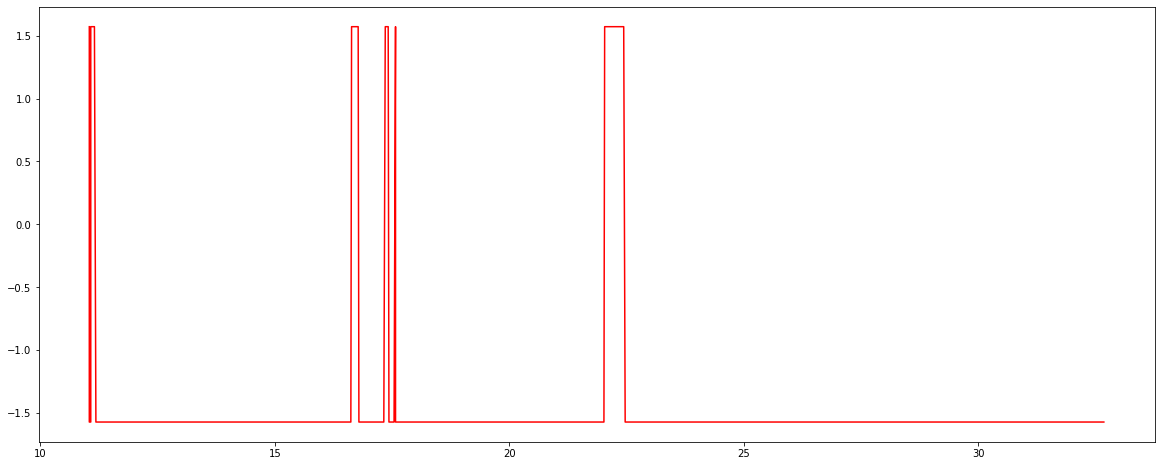

In [145]:
plt.figure(figsize=(20,8))
plt.plot(ori_time_1, ori_1[:,1],'r')
# plt.plot(ori_time_1, ori_1[:,2],'b')
plt.show()

In [146]:
filepath = 'test-ori4-output-2021-05-02-19-52-11.txt'

data1, data2 = init_data()
read_file(filepath, data1, data2)

# get data for myo 1
ori_time_1 = np.array(data1['ori']['time'])
ori_1 = np.array(data1['ori']['ori'])

acc_time_1 = np.array(data1['acc']['time'])
acc_1 = np.array(data1['acc']['acc'])/2048

gyr_time_1 = np.array(data1['gyr']['time'])
gyr_1 = np.array(data1['gyr']['gyr'])/16.4

# get data for myo 2
ori_time_2 = np.array(data2['ori']['time'])
ori_2 = np.array(data2['ori']['ori'])

acc_time_2 = np.array(data2['acc']['time'])
acc_2 = np.array(data2['acc']['acc'])/2048

gyr_time_2 = np.array(data2['gyr']['time'])
gyr_2 = np.array(data2['gyr']['gyr'])/16.4

In [153]:
plt.figure(figsize=(20,8))
plt.plot(ori_time_1, ori_1[:,2],'r')
plt.show()

In [167]:
filepath = 'test5-output-2021-05-02-22-15-55.txt'

data1, data2 = init_data()
read_file(filepath, data1, data2)

# get data for myo 1
ori_time_1 = np.array(data1['ori']['time'])
ori_1 = np.array(data1['ori']['ori'])

acc_time_1 = np.array(data1['acc']['time'])
acc_1 = np.array(data1['acc']['acc'])/2048

gyr_time_1 = np.array(data1['gyr']['time'])
gyr_1 = np.array(data1['gyr']['gyr'])/16.4

# get data for myo 2
ori_time_2 = np.array(data2['ori']['time'])
ori_2 = np.array(data2['ori']['ori'])

acc_time_2 = np.array(data2['acc']['time'])
acc_2 = np.array(data2['acc']['acc'])/2048

gyr_time_2 = np.array(data2['gyr']['time'])
gyr_2 = np.array(data2['gyr']['gyr'])/16.4

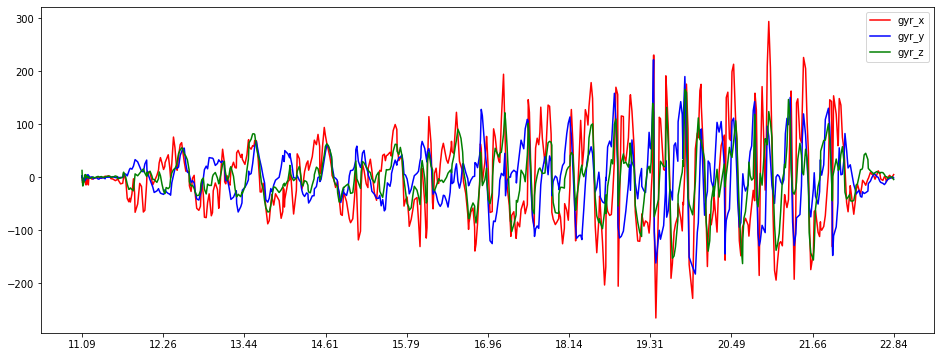

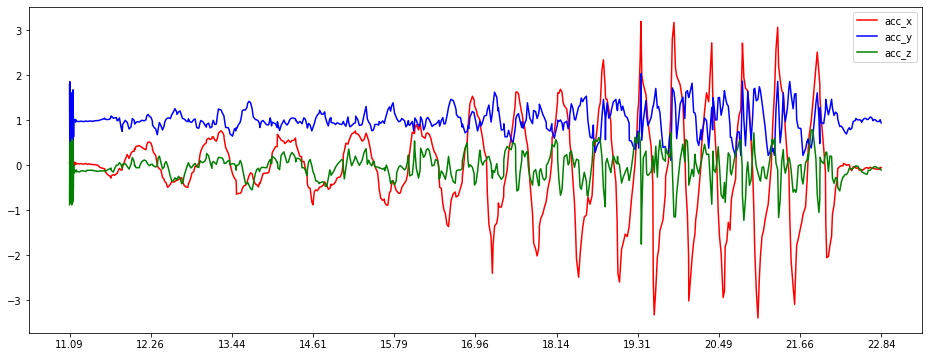

In [168]:
plot_data(gyr_time_1, gyr_1, 'gyr', 'xyz')
plot_data(acc_time_1, acc_1, 'acc', 'xyz')

In [169]:
filepath = 'test6-output-2021-05-02-22-26-37.txt'

data1, data2 = init_data()
read_file(filepath, data1, data2)

# get data for myo 1
ori_time_1 = np.array(data1['ori']['time'])
ori_1 = np.array(data1['ori']['ori'])

acc_time_1 = np.array(data1['acc']['time'])
acc_1 = np.array(data1['acc']['acc'])/2048

gyr_time_1 = np.array(data1['gyr']['time'])
gyr_1 = np.array(data1['gyr']['gyr'])/16.4

# get data for myo 2
ori_time_2 = np.array(data2['ori']['time'])
ori_2 = np.array(data2['ori']['ori'])

acc_time_2 = np.array(data2['acc']['time'])
acc_2 = np.array(data2['acc']['acc'])/2048

gyr_time_2 = np.array(data2['gyr']['time'])
gyr_2 = np.array(data2['gyr']['gyr'])/16.4

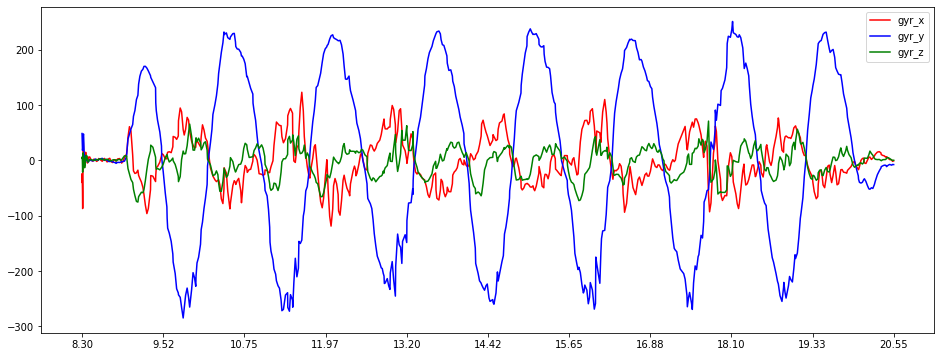

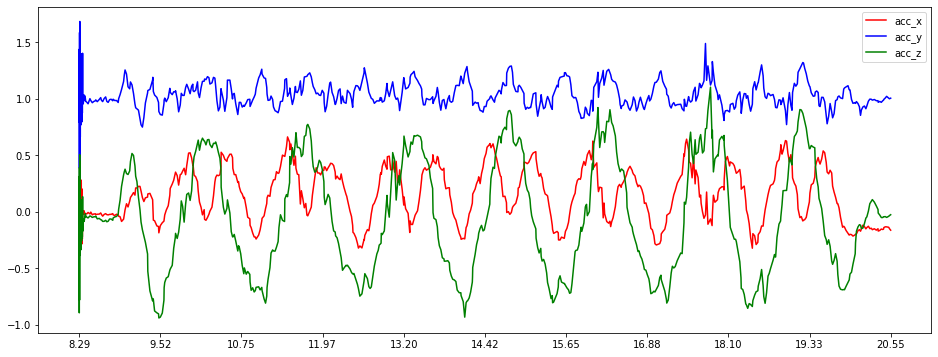

In [170]:
plot_data(gyr_time_1, gyr_1, 'gyr', 'xyz')
plot_data(acc_time_1, acc_1, 'acc', 'xyz')

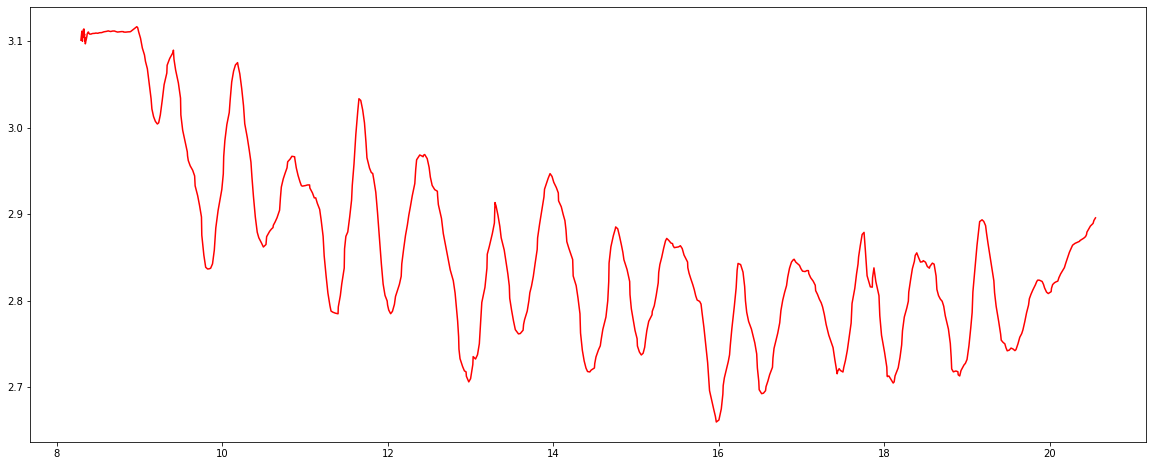

In [174]:
plt.figure(figsize=(20,8))
plt.plot(ori_time_1, ori_1[:,2],'r')
plt.show()

In [175]:
filepath = 'test7-output-2021-05-02-22-36-18.txt'

data1, data2 = init_data()
read_file(filepath, data1, data2)

# get data for myo 1
ori_time_1 = np.array(data1['ori']['time'])
ori_1 = np.array(data1['ori']['ori'])

acc_time_1 = np.array(data1['acc']['time'])
acc_1 = np.array(data1['acc']['acc'])/2048

gyr_time_1 = np.array(data1['gyr']['time'])
gyr_1 = np.array(data1['gyr']['gyr'])/16.4

# get data for myo 2
ori_time_2 = np.array(data2['ori']['time'])
ori_2 = np.array(data2['ori']['ori'])

acc_time_2 = np.array(data2['acc']['time'])
acc_2 = np.array(data2['acc']['acc'])/2048

gyr_time_2 = np.array(data2['gyr']['time'])
gyr_2 = np.array(data2['gyr']['gyr'])/16.4

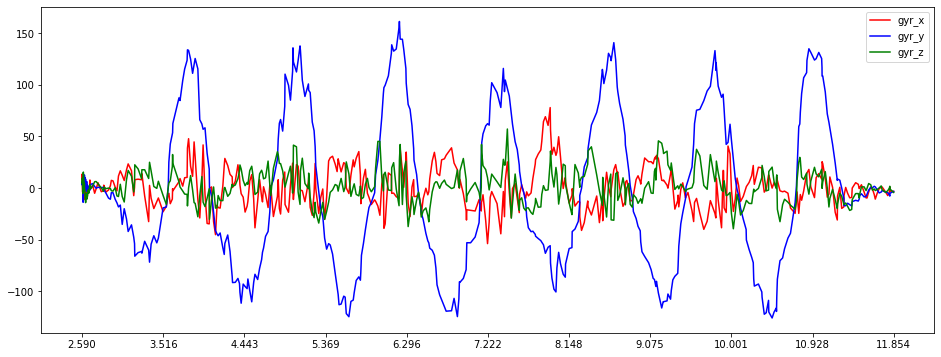

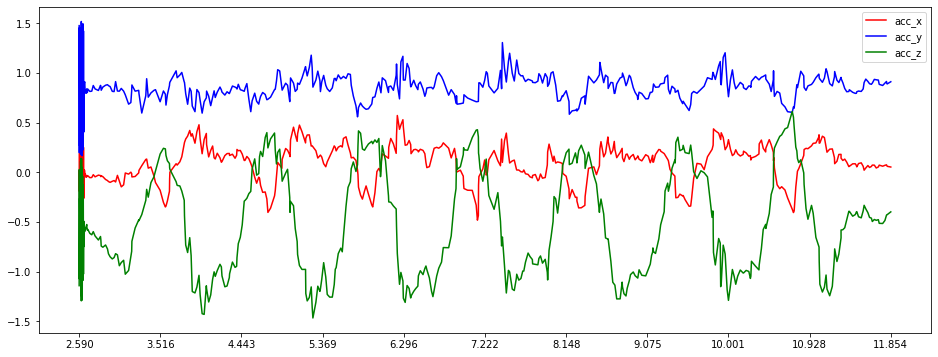

In [181]:
plot_data(gyr_time_1, gyr_1, 'gyr', 'xyz')
plot_data(acc_time_1, acc_1, 'acc', 'xyz')

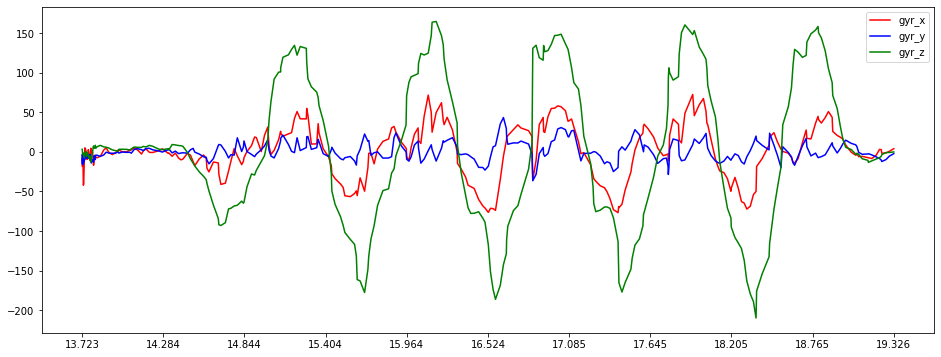

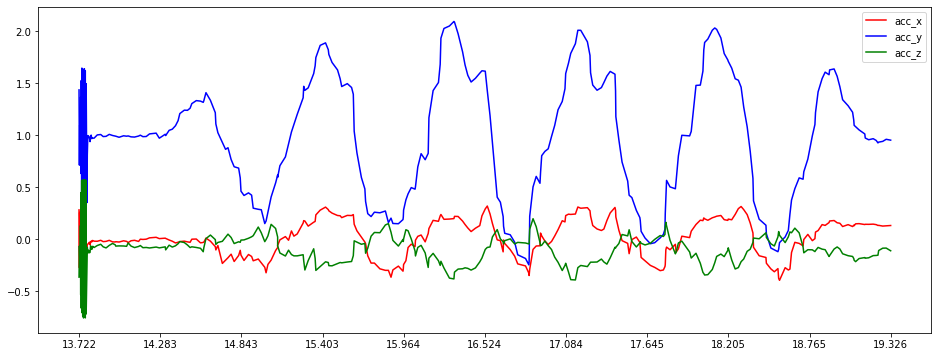

In [182]:
filepath = 'test8-output-2021-05-02-22-40-50.txt'

data1, data2 = init_data()
read_file(filepath, data1, data2)

# get data for myo 1
ori_time_1 = np.array(data1['ori']['time'])
ori_1 = np.array(data1['ori']['ori'])

acc_time_1 = np.array(data1['acc']['time'])
acc_1 = np.array(data1['acc']['acc'])/2048

gyr_time_1 = np.array(data1['gyr']['time'])
gyr_1 = np.array(data1['gyr']['gyr'])/16.4

# get data for myo 2
ori_time_2 = np.array(data2['ori']['time'])
ori_2 = np.array(data2['ori']['ori'])

acc_time_2 = np.array(data2['acc']['time'])
acc_2 = np.array(data2['acc']['acc'])/2048

gyr_time_2 = np.array(data2['gyr']['time'])
gyr_2 = np.array(data2['gyr']['gyr'])/16.4

plot_data(gyr_time_1, gyr_1, 'gyr', 'xyz')
plot_data(acc_time_1, acc_1, 'acc', 'xyz')

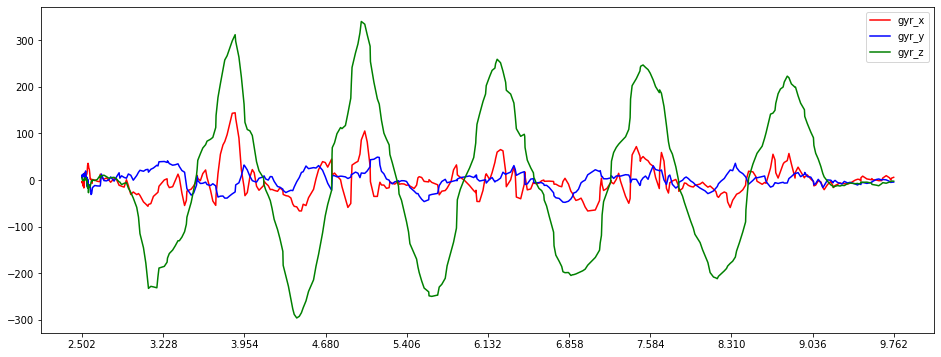

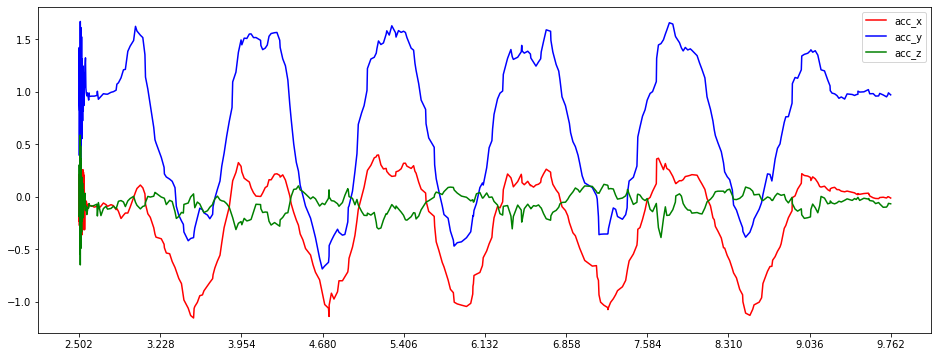

In [185]:
filepath = 'test9-output-2021-05-02-23-19-22.txt'

data1, data2 = init_data()
read_file(filepath, data1, data2)

# get data for myo 1
ori_time_1 = np.array(data1['ori']['time'])
ori_1 = np.array(data1['ori']['ori'])

acc_time_1 = np.array(data1['acc']['time'])
acc_1 = np.array(data1['acc']['acc'])/2048

gyr_time_1 = np.array(data1['gyr']['time'])
gyr_1 = np.array(data1['gyr']['gyr'])/16.4

# get data for myo 2
ori_time_2 = np.array(data2['ori']['time'])
ori_2 = np.array(data2['ori']['ori'])

acc_time_2 = np.array(data2['acc']['time'])
acc_2 = np.array(data2['acc']['acc'])/2048

gyr_time_2 = np.array(data2['gyr']['time'])
gyr_2 = np.array(data2['gyr']['gyr'])/16.4

plot_data(gyr_time_1, gyr_1, 'gyr', 'xyz')
plot_data(acc_time_1, acc_1, 'acc', 'xyz')

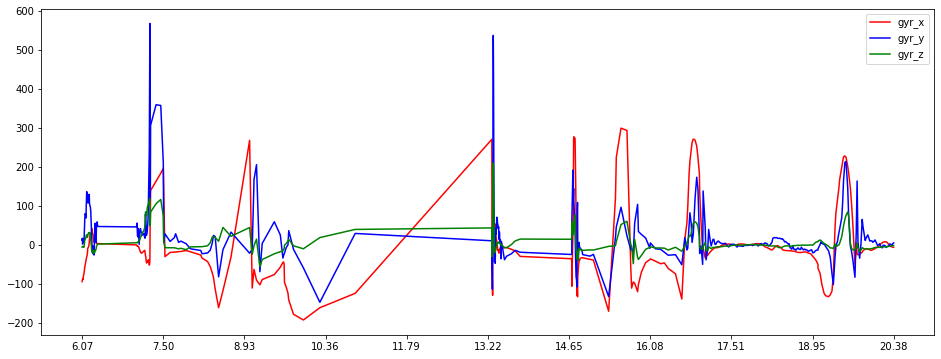

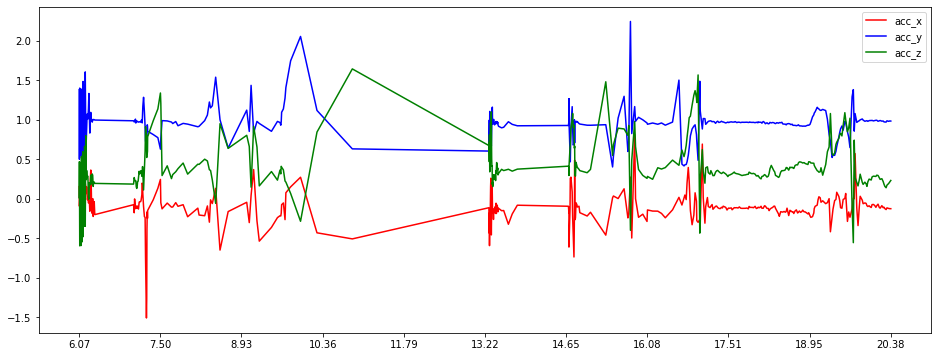

In [186]:
filepath = 'walk2-output-2021-05-03-07-36-25.txt'

data1, data2 = init_data()
read_file(filepath, data1, data2)

# get data for myo 1
ori_time_1 = np.array(data1['ori']['time'])
ori_1 = np.array(data1['ori']['ori'])

acc_time_1 = np.array(data1['acc']['time'])
acc_1 = np.array(data1['acc']['acc'])/2048

gyr_time_1 = np.array(data1['gyr']['time'])
gyr_1 = np.array(data1['gyr']['gyr'])/16.4

# get data for myo 2
ori_time_2 = np.array(data2['ori']['time'])
ori_2 = np.array(data2['ori']['ori'])

acc_time_2 = np.array(data2['acc']['time'])
acc_2 = np.array(data2['acc']['acc'])/2048

gyr_time_2 = np.array(data2['gyr']['time'])
gyr_2 = np.array(data2['gyr']['gyr'])/16.4

plot_data(gyr_time_1, gyr_1, 'gyr', 'xyz')
plot_data(acc_time_1, acc_1, 'acc', 'xyz')

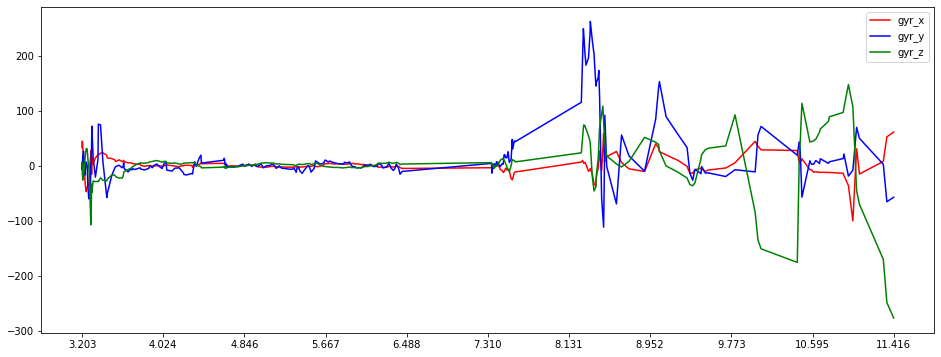

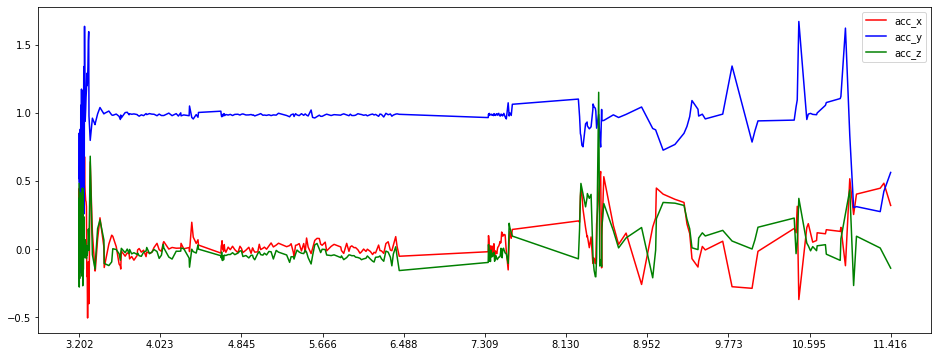

In [188]:
filepath = 'walk1-2-output-2021-05-03-07-31-41.txt'

data1, data2 = init_data()
read_file(filepath, data1, data2)

# get data for myo 1
ori_time_1 = np.array(data1['ori']['time'])
ori_1 = np.array(data1['ori']['ori'])

acc_time_1 = np.array(data1['acc']['time'])
acc_1 = np.array(data1['acc']['acc'])/2048

gyr_time_1 = np.array(data1['gyr']['time'])
gyr_1 = np.array(data1['gyr']['gyr'])/16.4

# get data for myo 2
ori_time_2 = np.array(data2['ori']['time'])
ori_2 = np.array(data2['ori']['ori'])

acc_time_2 = np.array(data2['acc']['time'])
acc_2 = np.array(data2['acc']['acc'])/2048

gyr_time_2 = np.array(data2['gyr']['time'])
gyr_2 = np.array(data2['gyr']['gyr'])/16.4

plot_data(gyr_time_1, gyr_1, 'gyr', 'xyz')
plot_data(acc_time_1, acc_1, 'acc', 'xyz')

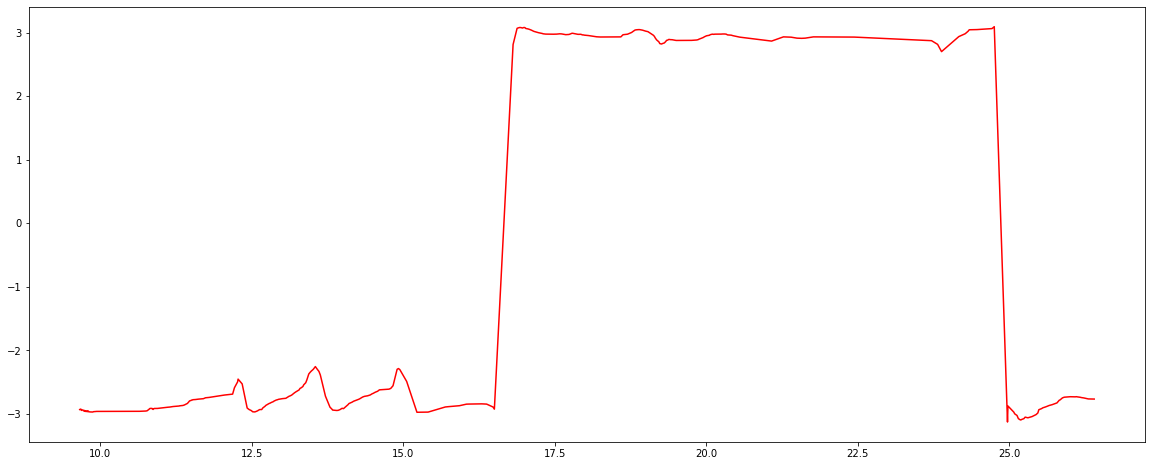

In [195]:
plt.figure(figsize=(20,8))
plt.plot(ori_time_1, ori_1[:,2],'r')
plt.show()

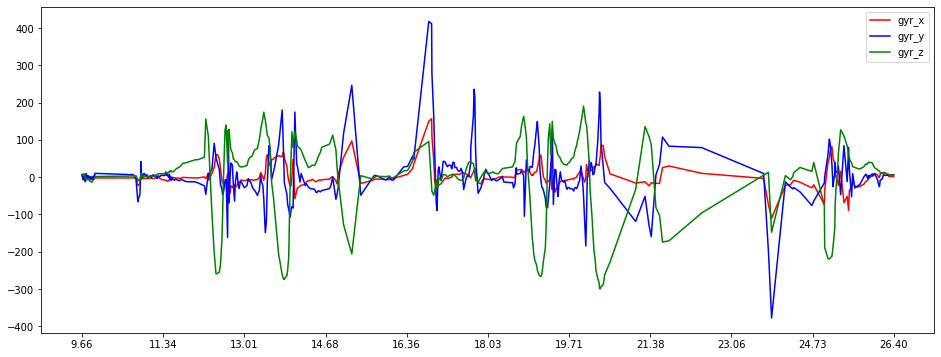

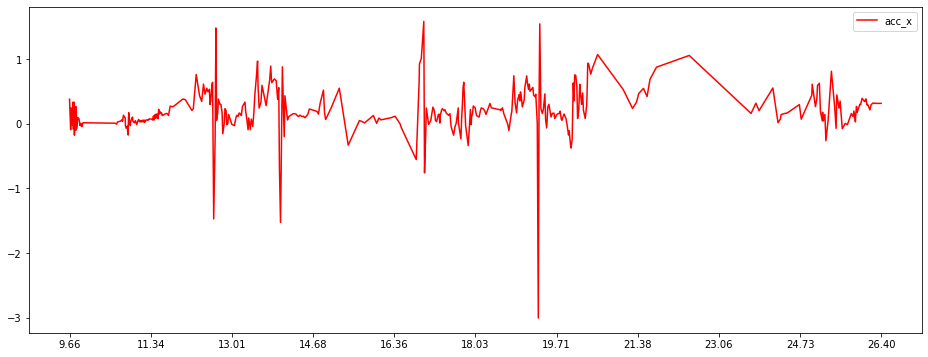

In [190]:
filepath = 'walk1-output-2021-05-03-08-03-14.txt'

data1, data2 = init_data()
read_file(filepath, data1, data2)

# get data for myo 1
ori_time_1 = np.array(data1['ori']['time'])
ori_1 = np.array(data1['ori']['ori'])

acc_time_1 = np.array(data1['acc']['time'])
acc_1 = np.array(data1['acc']['acc'])/2048

gyr_time_1 = np.array(data1['gyr']['time'])
gyr_1 = np.array(data1['gyr']['gyr'])/16.4

# get data for myo 2
ori_time_2 = np.array(data2['ori']['time'])
ori_2 = np.array(data2['ori']['ori'])

acc_time_2 = np.array(data2['acc']['time'])
acc_2 = np.array(data2['acc']['acc'])/2048

gyr_time_2 = np.array(data2['gyr']['time'])
gyr_2 = np.array(data2['gyr']['gyr'])/16.4

plot_data(gyr_time_1, gyr_1, 'gyr', 'xyz')
plot_data(acc_time_1, acc_1, 'acc', 'x')

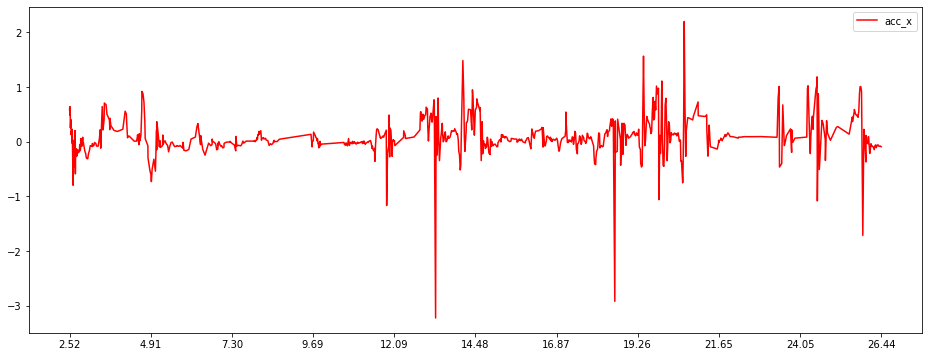

In [192]:
plot_data(gyr_time_2, gyr_2, 'gyr', 'z')
plot_data(acc_time_2, acc_2, 'acc', 'x')

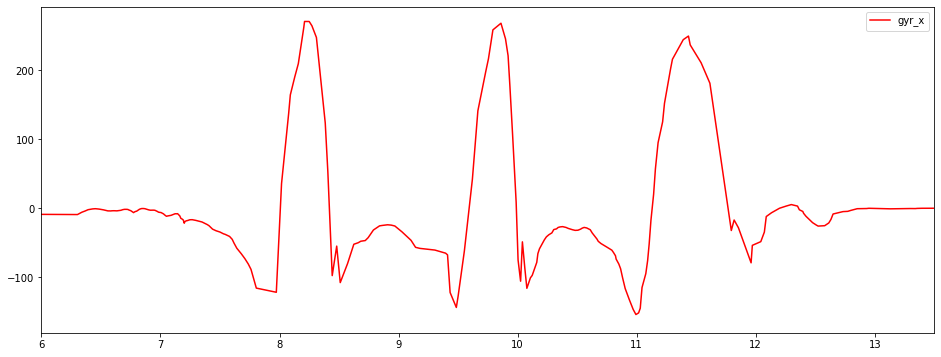

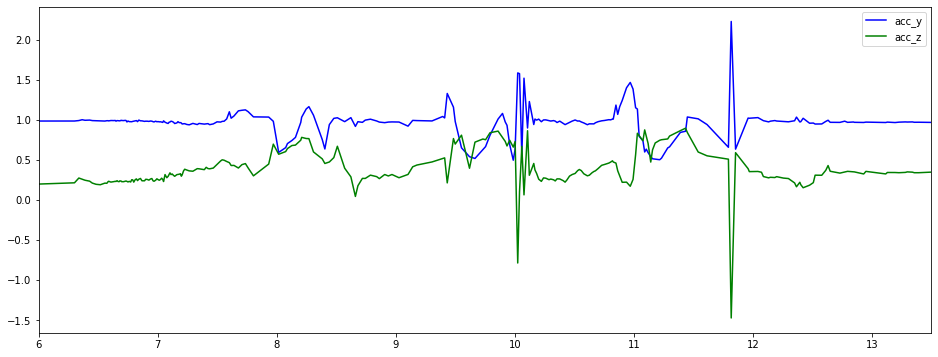

In [257]:
filepath = 'walk2-output-2021-05-03-20-25-58.txt'

data1, data2 = init_data()
read_file(filepath, data1, data2)

# get data for myo 1
ori_time_1 = np.array(data1['ori']['time'])
ori_1 = np.array(data1['ori']['ori'])

acc_time_1 = np.array(data1['acc']['time'])
acc_1 = np.array(data1['acc']['acc'])/2048

gyr_time_1 = np.array(data1['gyr']['time'])
gyr_1 = np.array(data1['gyr']['gyr'])/16.4

# get data for myo 2
ori_time_2 = np.array(data2['ori']['time'])
ori_2 = np.array(data2['ori']['ori'])

acc_time_2 = np.array(data2['acc']['time'])
acc_2 = np.array(data2['acc']['acc'])/2048

gyr_time_2 = np.array(data2['gyr']['time'])
gyr_2 = np.array(data2['gyr']['gyr'])/16.4

plot_data(gyr_time_1, gyr_1, 'gyr', [6, 13.5], 'x')
plot_data(acc_time_1, acc_1, 'acc', [6, 13.5], 'yz')

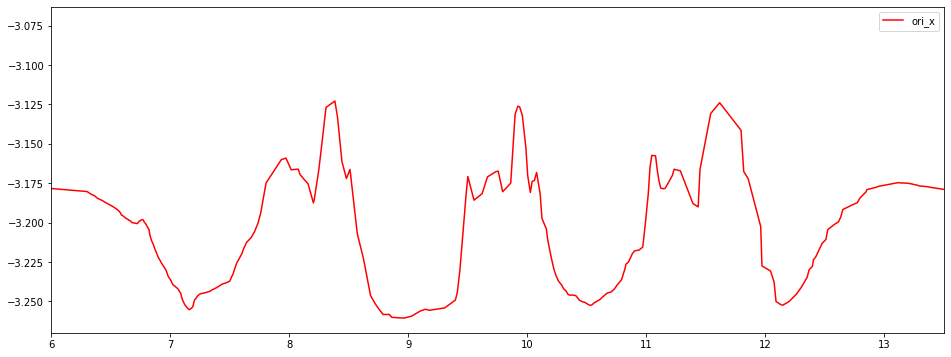

In [258]:
ori_1[:,0] = [x if x > 0 else x+2*math.pi for x in ori_1[:,0]]
ori_1[:,2] = [x if x > 0 else x+2*math.pi for x in ori_1[:,2]]
plot_data(ori_time_1, -ori_1, 'ori', [6, 13.5], 'x')
plot_data(ori_time_1, ori_1, 'ori', [6, 13.5], 'z')

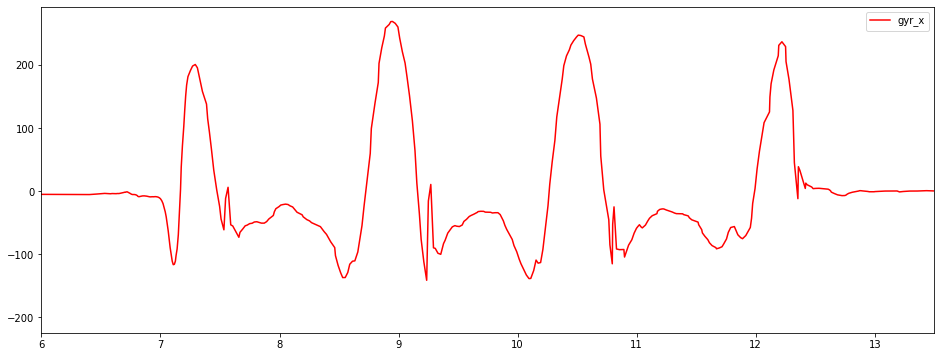

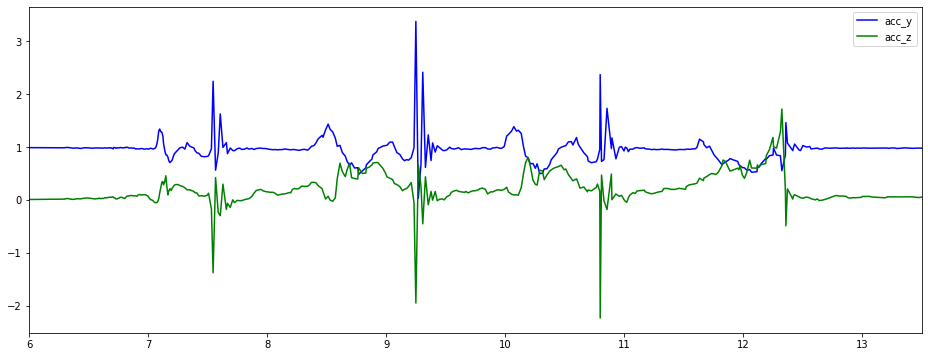

In [259]:
plot_data(gyr_time_2, gyr_2, 'gyr', [6, 13.5], 'x')
plot_data(acc_time_2, acc_2, 'acc', [6, 13.5], 'yz')

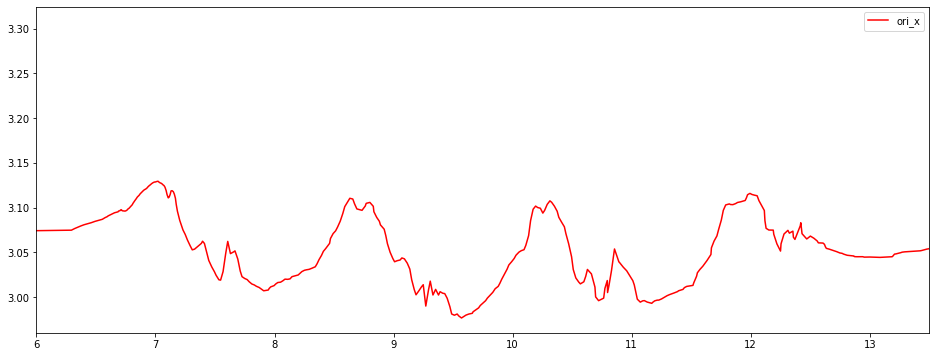

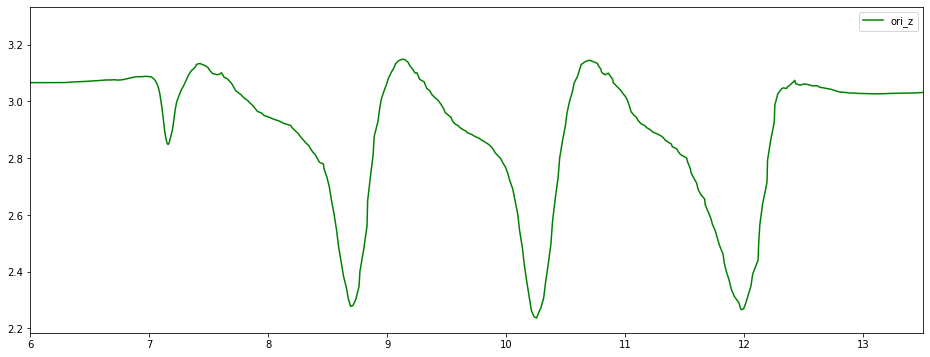

In [256]:
# ori_2[:,0] = [x if x > 0 else x+2*math.pi for x in ori_2[:,0]]
# ori_2[:,2] = [x if x > 0 else x+2*math.pi for x in ori_2[:,2]]
plot_data(ori_time_2, ori_2, 'ori', [6, 13.5], 'x')
plot_data(ori_time_2, ori_2, 'ori', [6, 13.5], 'z')

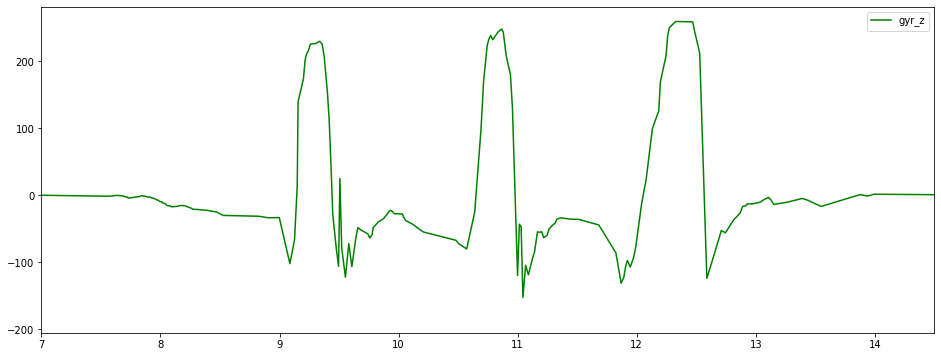

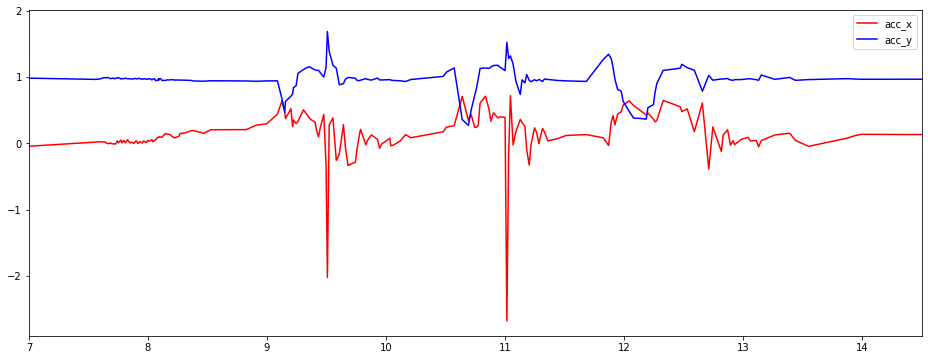

In [260]:
filepath = 'walk1-output-2021-05-03-20-23-32.txt'

data1, data2 = init_data()
read_file(filepath, data1, data2)

# get data for myo 1
ori_time_1 = np.array(data1['ori']['time'])
ori_1 = np.array(data1['ori']['ori'])

acc_time_1 = np.array(data1['acc']['time'])
acc_1 = np.array(data1['acc']['acc'])/2048

gyr_time_1 = np.array(data1['gyr']['time'])
gyr_1 = np.array(data1['gyr']['gyr'])/16.4

# get data for myo 2
ori_time_2 = np.array(data2['ori']['time'])
ori_2 = np.array(data2['ori']['ori'])

acc_time_2 = np.array(data2['acc']['time'])
acc_2 = np.array(data2['acc']['acc'])/2048

gyr_time_2 = np.array(data2['gyr']['time'])
gyr_2 = np.array(data2['gyr']['gyr'])/16.4

plot_data(gyr_time_1, -gyr_1, 'gyr', [7, 14.5], 'z')
plot_data(acc_time_1, acc_1, 'acc', [7, 14.5], 'xy')

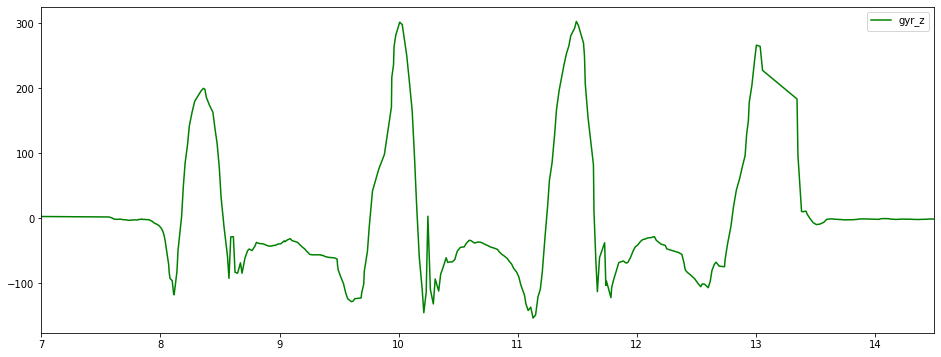

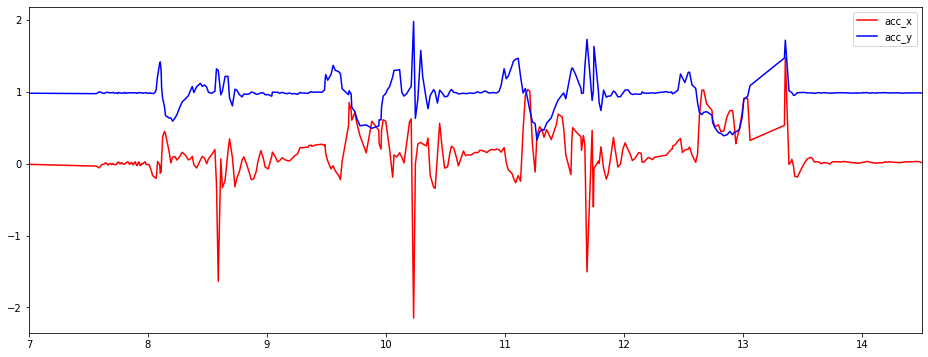

In [261]:
plot_data(gyr_time_2, -gyr_2, 'gyr', [7, 14.5], 'z')
plot_data(acc_time_2, acc_2, 'acc', [7, 14.5], 'xy')

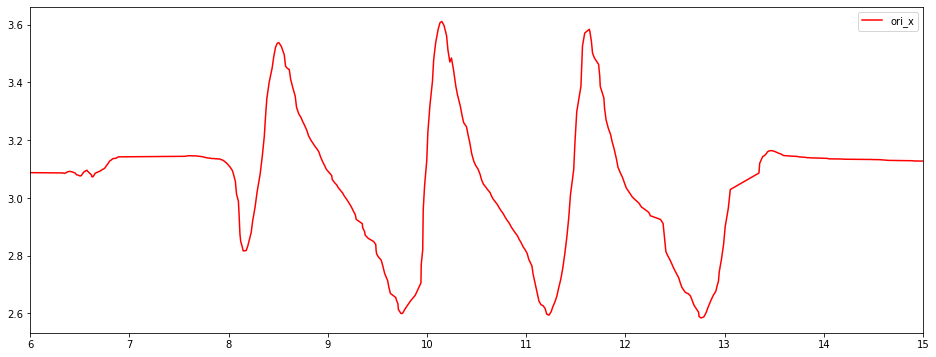

In [266]:
# ori_2[:,0] = [x if x > 0 else x+2*math.pi for x in ori_2[:,0]]
# ori_2[:,2] = [x if x > 0 else x+2*math.pi for x in ori_2[:,2]]
plot_data(ori_time_2, ori_2, 'ori', [6, 15], 'x')
plot_data(ori_time_2, ori_2, 'ori', [6, 15], 'z')

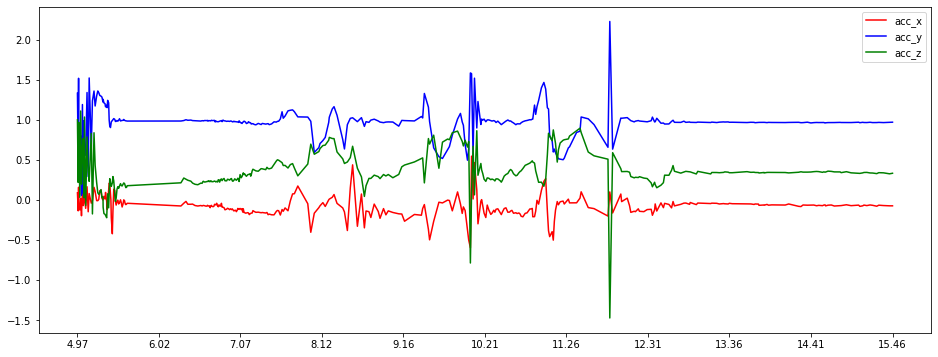

In [209]:
plot_data(acc_time_1, acc_1, 'acc', 'x')

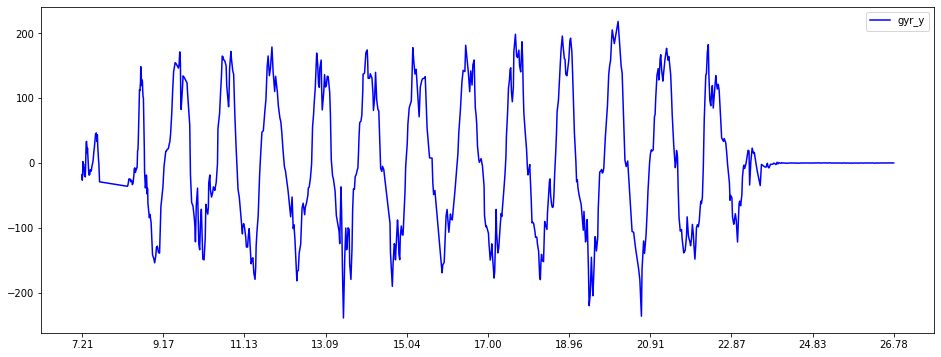

217.7439024390244


In [9]:
plot_data(gyr_time_1, gyr_1, 'gyr', 'y')
print(max(gyr_1[:,1]))

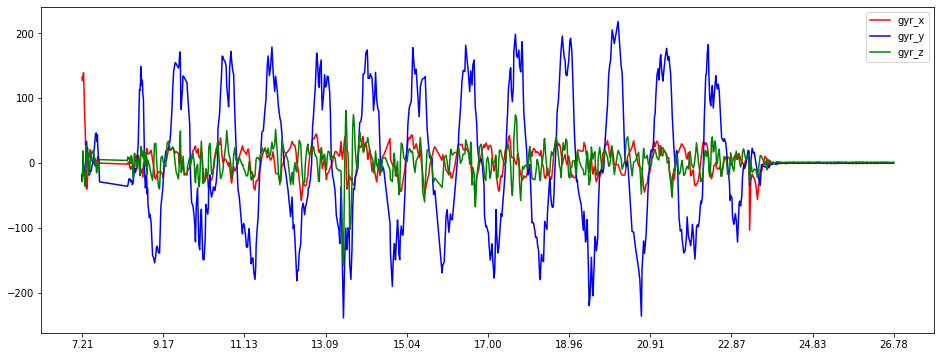

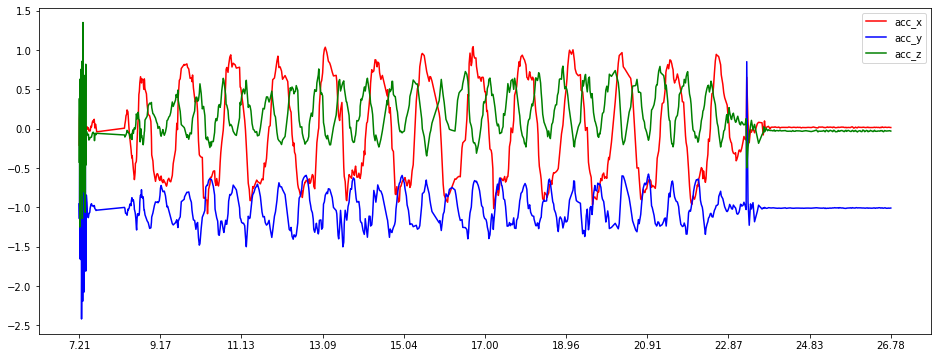

In [12]:
plot_data(gyr_time_1, gyr_1, 'gyr', 'xyz')
plot_data(acc_time_1, acc_1, 'acc', 'xyz')

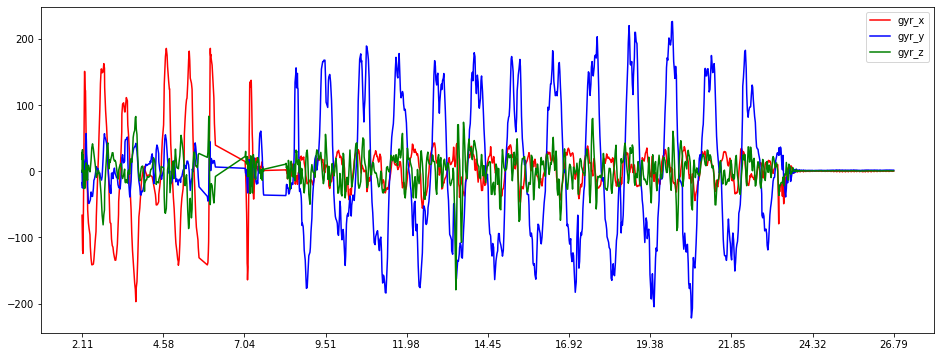

In [13]:
plot_data(gyr_time_2, gyr_2, 'gyr', 'xyz')
plot_data(acc_time_2, acc_2, 'acc', 'xyz')